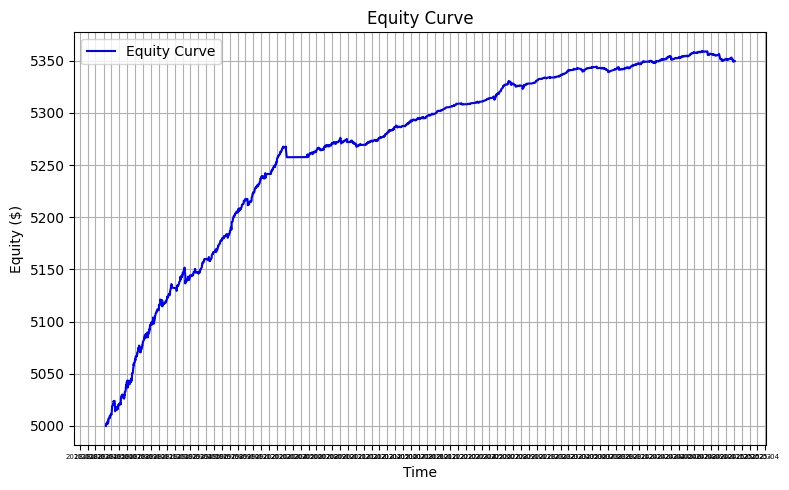

,Symbol,Win Rate,Number of Trades,Consecutive Wins,Consecutive Losses,Gross Profit,Gross Loss,Total Profit/Loss,Profit Factor,Average Profit,Average Loss,Risk/Reward Ratio,Total Commission,Total Swap,Trade Expectation
0,EURUSD,74.08%,868,17,5,$214.46,$-86.76,$127.70,2.471876,$0.33,$-0.39,0.864965,$-53.32,$-8.11,$0.15
1,GBPUSD,71.98%,653,23,4,$198.83,$-92.40,$106.43,2.15184,$0.42,$-0.50,0.837844,$-39.67,$-5.40,$0.16
2,USDCHF,67.29%,376,10,4,$102.63,$-63.42,$39.21,1.618259,$0.41,$-0.52,0.786743,$-24.49,$0.27,$0.10
3,EURCHF,65.59%,619,29,6,$142.57,$-96.15,$46.42,1.482787,$0.35,$-0.45,0.777916,$-40.91,$-8.06,$0.07
4,EURAUD,77.91%,86,14,2,$27.39,$-13.28,$14.11,2.0625,$0.41,$-0.70,0.584888,$-4.29,$0.00,$0.16
5,USDCAD,79.46%,112,16,3,$20.78,$-11.39,$9.39,1.824407,$0.23,$-0.50,0.471476,$-5.08,$0.00,$0.08
6,EURCAD,82.35%,34,10,2,$9.12,$-2.73,$6.39,3.340659,$0.33,$-0.46,0.715856,$-1.61,$0.00,$0.19
7,TOTAL,74.09%,2748,-,-,$715.78,$-366.13,$349.65,1.95,$0.35,$-0.50,0.70,$-169.37,$-21.30,$0.13


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Başlangıç sermayesi (parametrik)
initial_balance = 5000  # USD

# Excel dosyasını yükleme
file_path = r'C:\Users\PC\Desktop\Sistem_Test\trend_change_pullback.xlsx' 
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına dönüştürme
data['Time'] = pd.to_datetime(data['Time'])

# Veriyi tarihe göre sıralama (geçmişten günümüze)
data = data.sort_values(by='Time').reset_index(drop=True)

# Kümülatif kâr/zarar, komisyon ve swap hesaplama
data['Cumulative Profit'] = data['Profit'].cumsum()
data['Cumulative Commission'] = data['Commission'].cumsum()
data['Cumulative Swap'] = data['Swap'].cumsum()
data['Equity'] = initial_balance + data['Cumulative Profit']

# Equity grafiği çizimi
plt.figure(figsize=(8, 5))
plt.plot(data['Time'], data['Equity'], label='Equity Curve', color='blue')

# X ekseninde yalnızca ay başlarını göster
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())  # Her ay başını işaretle
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Ay ve yıl formatında göster
plt.xticks(fontsize=5)  # Tarih yazı puntosunu küçült

plt.title('Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Genel metrikler hesaplama
def calculate_metrics(data_subset):
    wins = data_subset['Profit'] > 0
    losses = data_subset['Profit'] <= 0
    win_rate = wins.sum() / len(data_subset)
    num_trades = len(data_subset)

    def consecutive_count(series):
        counts = (series != series.shift()).cumsum()
        return series.groupby(counts).cumsum().max()

    consecutive_wins = consecutive_count(wins)
    consecutive_losses = consecutive_count(losses)

    gross_profit = data_subset.loc[data_subset['Profit'] > 0, 'Profit'].sum()
    gross_loss = data_subset.loc[data_subset['Profit'] <= 0, 'Profit'].sum()
    total_profit_loss = gross_profit + gross_loss
    profit_factor = gross_profit / abs(gross_loss) if gross_loss != 0 else '-'

    average_profit = data_subset.loc[data_subset['Profit'] > 0, 'Profit'].mean()
    average_loss = data_subset.loc[data_subset['Profit'] <= 0, 'Profit'].mean() if losses.sum() > 0 else 0
    risk_reward_ratio = average_profit / abs(average_loss) if average_loss != 0 else '-'

    total_commission = data_subset['Commission'].sum()
    total_swap = data_subset['Swap'].sum()

    expectation = (win_rate * average_profit) - ((1 - win_rate) * abs(average_loss)) if average_loss != 0 else (win_rate * average_profit)

    return {
        'Win Rate': f"{win_rate:.2%}",
        'Number of Trades': num_trades,
        'Consecutive Wins': consecutive_wins,
        'Consecutive Losses': consecutive_losses,
        'Gross Profit': f"${gross_profit:.2f}",
        'Gross Loss': f"${gross_loss:.2f}",
        'Total Profit/Loss': f"${total_profit_loss:.2f}",
        'Profit Factor': profit_factor,
        'Average Profit': f"${average_profit:.2f}",
        'Average Loss': f"${average_loss:.2f}",
        'Risk/Reward Ratio': risk_reward_ratio,
        'Total Commission': f"${total_commission:.2f}",
        'Total Swap': f"${total_swap:.2f}",
        'Trade Expectation': f"${expectation:.2f}"
    }

# Sembol bazında analiz
symbols = data['Symbol'].unique()
symbol_results = {}

for symbol in symbols:
    symbol_data = data[data['Symbol'] == symbol]
    symbol_results[symbol] = calculate_metrics(symbol_data)

# Tüm semboller için toplamlar
total_gross_profit = data.loc[data['Profit'] > 0, 'Profit'].sum()
total_gross_loss = data.loc[data['Profit'] <= 0, 'Profit'].sum()
total_profit_loss = total_gross_profit + total_gross_loss
total_commission = data['Commission'].sum()
total_swap = data['Swap'].sum()

# Ortalama hesaplamalar
average_win_rate = sum([float(metrics['Win Rate'].strip('%')) for metrics in symbol_results.values()]) / len(symbol_results)

# Profit Factor, Gross Profit / Gross Loss ile hesaplanmalı
total_profit_factor = total_gross_profit / abs(total_gross_loss) if total_gross_loss != 0 else '-'

# Average Loss için tüm sembollerin değerlerini kullanarak hesaplama
average_avg_loss = sum([float(metrics['Average Loss'].strip('$')) for metrics in symbol_results.values()]) / len(symbol_results)

# Average Profit
average_avg_profit = sum([float(metrics['Average Profit'].strip('$')) for metrics in symbol_results.values()]) / len(symbol_results)

# Risk/Reward Ratio, Average Profit / Average Loss ile hesaplanmalı
total_risk_reward_ratio = average_avg_profit / abs(average_avg_loss) if average_avg_loss != 0 else '-'

# Trade Expectation, TOTAL row için yeniden hesaplanmalı
trade_expectation_total = (average_win_rate / 100 * average_avg_profit) - ((1 - (average_win_rate / 100)) * abs(average_avg_loss)) if average_avg_loss != 0 else (average_win_rate / 100 * average_avg_profit)

# TOTAL ekle
symbol_results['TOTAL'] = {
    'Win Rate': f"{average_win_rate:.2f}%",
    'Number of Trades': len(data),
    'Consecutive Wins': '-',
    'Consecutive Losses': '-',
    'Gross Profit': f"${total_gross_profit:.2f}",
    'Gross Loss': f"${total_gross_loss:.2f}",
    'Total Profit/Loss': f"${total_profit_loss:.2f}",
    'Profit Factor': f"{total_profit_factor:.2f}" if total_profit_factor != '-' else '-',
    'Average Profit': f"${average_avg_profit:.2f}",
    'Average Loss': f"${average_avg_loss:.2f}",
    'Risk/Reward Ratio': f"{total_risk_reward_ratio:.2f}" if total_risk_reward_ratio != '-' else '-',
    'Total Commission': f"${total_commission:.2f}",
    'Total Swap': f"${total_swap:.2f}",
    'Trade Expectation': f"${trade_expectation_total:.2f}"
}

# Sonuçları tablo olarak gösterme
symbol_results_df = pd.DataFrame(symbol_results).T.reset_index()
symbol_results_df.columns = ["Symbol"] + list(symbol_results_df.columns[1:])
symbol_results_df
